<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw2/hw2_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement an flow model and run it on one to two datasets. We provide the expected outputs to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [1]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git 
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 758 (delta 1), reused 0 (delta 0), pack-reused 749
Receiving objects: 100% (758/758), 117.08 MiB | 36.10 MiB/s, done.
Resolving deltas: 100% (346/346), done.
Checking out files: 100% (129/129), done.
Processing ./deepul
  Created wheel for deepul: filename=deepul-0.1.0-cp36-none-any.whl size=16677 sha256=5bb501e9c2c76bc0f5245b80d30dce6199925d67c96626921ecde4461b1df95c
  Stored in directory: /tmp/pip-ephem-wheel-cache-04x0tv5o/wheels/39/1a/4b/a6f51db275abb2e5dae32540e06ed5011e792f162467bd3aa8
Successfully built deepul


In [2]:
from deepul.hw2_helper import *

# Question 2: Autoregressive Flows for Images [20pt]
We can scale up the autoregressive flows from 1(a) to high-dimensional image data. In this question, we will focus on the black-and-white shapes dataset from Homework 1.

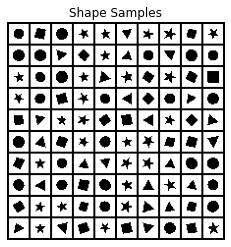

In [3]:
visualize_q2_data()

Adapt your PixelCNN implementation from Homework 1 and use it as an autoregressive flow model on the black-and-white shapes dataset. Using the base architecture from Homework 1 3(a), output a mixture of logistics or gaussians (instead of logits), whose CDF we will use as our flow for each dimension of x. 

Remember: you must dequantize the data and scale it between 0 and 1 for the autoregressive flow to have stable training. 

**You will provide these deliverables**

1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. **Make sure to account for any rescaling you do in your nats/dim.**
2.   Report the final test set performance of your final model
3. 100 samples from your autoregressive flow. Our plotting code will show your samples, with and without clipping and flooring (to remove the quantization). 


### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [92]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal

import deepul.pytorch_util as ptu

import numpy as np

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [93]:
class MaskedCon2d(nn.Conv2d):
  def __init__(self, color_conditioning, mask_type, **kwargs):
    super().__init__(**kwargs)
    self.color_conditioning = color_conditioning
    self.mask = torch.zeros_like(self.weight).to(DEVICE)
    self.create_mask(mask_type)
  
  def forward(self, x):
    batch_size = x.shape[0]
    out = F.conv2d(x, self.weight * self.mask, self.bias, self.stride,
                   self.padding, self.dilation, self.groups)
    return out

  def create_mask(self, mask_type):
    k = self.kernel_size[0]
    # C_out, C_in, H, W
    self.mask[:, :, :k // 2] = 1 # all rows in the upper half
    self.mask[:, :, k // 2, :k // 2] = 1 # all elements in the left half of the center row

    if self.color_conditioning:
      assert self.in_channels % 3 ==0 and self.out_channels % 3 == 0
      c_in_each_color = self.in_channels // 3
      c_out_each_color = self.out_channels // 3
      if mask_type == 'B':
        self.mask[:c_out_each_color, :c_in_each_color, k//2, k//2 ] = 1
        self.mask[c_out_each_color:(2*c_out_each_color), :(2 * c_in_each_color), k//2, k//2 ] = 1
        self.mask[(2*c_out_each_color):, :, k//2, k//2 ] = 1
      
      else:
        self.mask[c_out_each_color:(2*c_out_each_color), :c_in_each_color, k//2, k//2] = 1
        self.mask[(2*c_out_each_color):, :(2 * c_in_each_color), k//2, k//2] = 1
    
    else:
      if mask_type == 'B':
        # add the center
        self.mask[:, :, k // 2, k // 2] = 1


In [94]:
class ResidualBlock(nn.Module):
  def __init__(self, color_conditioning, in_channels):
    super().__init__()
    self.net = nn.ModuleList([nn.ReLU(),
                              MaskedCon2d(mask_type='B', color_conditioning=color_conditioning,
                                         in_channels=in_channels, out_channels=in_channels // 2, kernel_size=1),
                              nn.ReLU(),
                              MaskedCon2d(mask_type='B', color_conditioning=color_conditioning,
                                         in_channels=in_channels // 2, out_channels=in_channels // 2, kernel_size=7, padding=3),
                              nn.ReLU(),
                              MaskedCon2d(mask_type='B', color_conditioning=color_conditioning,
                                         in_channels=in_channels // 2, out_channels=in_channels, kernel_size=1)
        ])
  def forward(self, x):
    out = x
    for l in self.net:
      out = l(out)
    return out + x

In [95]:
def train(model, train_loader, optimizer):
    model.train()
    losses = []
    for x in train_loader:
        x = x.to(DEVICE).float().contiguous()
        loss = model.loss(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

def eval_loss(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x in data_loader:
            x = x.to(DEVICE).float().contiguous()
            loss = model.loss(x)
            total_loss += loss * x.shape[0]
        avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss.item()

def train_epochs(model, train_loader, test_loader, train_args):
    epochs, lr = train_args['epochs'], train_args['lr']
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = [], []
    test_loss = eval_loss(model, test_loader)
    test_losses.append(test_loss)  # loss at init
    for epoch in range(epochs):
        model.train()
        epoch_train_losses = train(model, train_loader, optimizer) 
        train_losses.extend(epoch_train_losses)

        test_loss = eval_loss(model, test_loader)
        test_losses.append(test_loss)

        print(f"EPOCH {epoch}, test loss: {test_loss}")
            
    return train_losses, test_losses

In [124]:
class PixelCNN_ARFlow(nn.Module):
  """
  instead of outputting 256 logits for each pixel, 
  output a cdf of a mixture of gaussian

  x1 -> F(x1; m,std) -> z1
  x2 -> F(x2; x1) -> F(x2; m, std = f(x1)) -> z2
  xn -> F(xn; x1...xn-1) -> F(xn; m, std = f(x1...xn-1)) -> zn

  F is mixture of Gaussian
  f is PixelCNN

  """

  def __init__(self, input_shape, num, n_filters=64,
               color_conditioning=False):
    super().__init__()
    self.num = num
    n_channels = input_shape[0]
    self.net = nn.ModuleList([MaskedCon2d(mask_type='A', color_conditioning=color_conditioning,
                                          in_channels=n_channels, out_channels=n_filters, kernel_size=7, padding=7//2)])
    for _ in range(5):
      self.net.extend([ResidualBlock(color_conditioning, in_channels=n_filters)])
    
    self.net.extend([nn.ReLU(),
                     MaskedCon2d(mask_type='B', 
                                 color_conditioning=color_conditioning,
                                 in_channels=n_filters,
                                 out_channels=3 * num * n_channels,
                                 kernel_size=1)])
  
    self.input_shape = input_shape

    self.n_channels = n_channels
    self.color_conditioning = color_conditioning


  def forward(self, x, add=True):
    batch_size = x.shape[0]
    out = x.float() 
    if add:
      out += Uniform(0.0, 0.5).sample(x.shape).to(DEVICE)

    for layer in self.net:
        out = layer(out)

    # B * 3*num * C * H * W
    out = out.view(batch_size, 3 * self.num, *self.input_shape)
    return out

  def loss(self, x):
    batch_size = x.shape[0]
    forward_out = self(x)
    # B * C * H * W
    out = forward_out
    m, log_std, weight_logit = torch.chunk(out, 3, dim=1)
    # B * num * C * H * W
    weight = F.softmax(weight_logit, dim=1)
    # z = MixtureOfNormalCDF(x) therefore uniform, pz is cons therefore can be ingored
    # log_p_z = 0
    # therefore we only need log abs det dz/dx
    # z is MixtureOfNormalCDF(x)
    # therefore dz/dx is pdf (x) also diagonal
    # therefore sum log pdf(x)
    prob = Normal(m, log_std.exp())\
           .log_prob(x.unsqueeze(1).repeat(1, self.num, 1, 1, 1))\
           .exp()
    # prob = (prob * weight).sum(dim=1)
    out = - prob.log().mean()
    return out

  def sample(self, n):
    samples = torch.zeros(n, *self.input_shape).to(DEVICE)
    first_pixel = True
    with torch.no_grad():
      for r in range(self.input_shape[1]):
        for c in range(self.input_shape[2]):
          for k in range(self.n_channels):
            out = self(samples, add=first_pixel)[:,:,k,r,c].squeeze()
            first_pixel = False
            m, log_std, weight_logit = torch.chunk(out, 3, dim=1)

            weight = F.softmax(weight_logit.squeeze(), dim=1)
            components = torch.multinomial(weight, 1).squeeze(-1)
            # to_add = torch.sum((sample_ * weight), dim=1)
            samples[:, k, r, c] = torch.normal(m[torch.arange(n), components], log_std[torch.arange(n), components].exp())
    #         probs = F.softmax(logits, dim=1)
    #         samples[:, k, r, c] = torch.multinomial(probs, 1).squeeze(-1)
    return samples.permute(0, 2, 3, 1).cpu().numpy()



In [125]:
def q2(train_data, test_data):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  H = W = 20
  Note that you should dequantize your train and test data, your dequantized pixels should all lie in [0,1]

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in [0, 1], where [0,0.5] represents a black pixel
      and [0.5,1] represents a white pixel. We will show your samples with and without noise. 
  """
  
  """ YOUR CODE HERE """
  train_data = np.transpose(train_data, (0, 3, 1, 2)).astype(np.float32) / 2.0
  test_data = np.transpose(test_data, (0, 3, 1, 2)).astype(np.float32) / 2.0

  H, W = 20, 20
  model = PixelCNN_ARFlow((1, H, W), 10).to(DEVICE)

  loader_arg = dict(batch_size=128, shuffle=True)
  train_loader = data.DataLoader(train_data, **loader_arg)
  test_loader = data.DataLoader(test_data, **loader_arg)
  train_losses, test_losses = train_epochs(model, train_loader, test_loader, 
                                           dict(epochs=20, lr=1e-3))
  samples = model.sample(100)
  return train_losses + np.log(2), test_losses + np.log(2), samples

### Results

Once you've implemented `q2`, execute the cells below to visualize and save your results



EPOCH 0, test loss: -0.28829124569892883
EPOCH 1, test loss: -0.34420937299728394
EPOCH 2, test loss: -0.36522066593170166
EPOCH 3, test loss: -0.38808873295783997
EPOCH 4, test loss: -0.3985562324523926
EPOCH 5, test loss: -0.3996647298336029
EPOCH 6, test loss: -0.410089373588562
EPOCH 7, test loss: -0.40920621156692505
EPOCH 8, test loss: -0.4148992598056793
EPOCH 9, test loss: -0.42089852690696716
EPOCH 10, test loss: -0.42342695593833923
EPOCH 11, test loss: -0.421314537525177
EPOCH 12, test loss: -0.42898404598236084
EPOCH 13, test loss: -0.42963096499443054
EPOCH 14, test loss: -0.4349704682826996
EPOCH 15, test loss: -0.43752771615982056
EPOCH 16, test loss: -0.4367293417453766
EPOCH 17, test loss: -0.4406348168849945
EPOCH 18, test loss: -0.4414006769657135
EPOCH 19, test loss: -0.4401569664478302
Final Test Loss: 0.2530


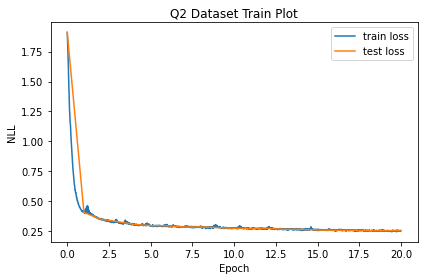

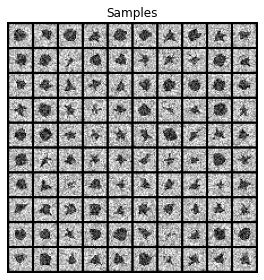

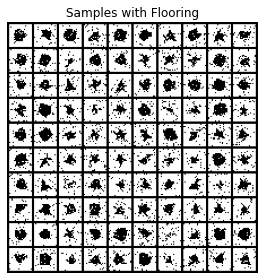

In [126]:
q2_save_results(q2)